# Quantum Process Tomography via Genetic Algorithms

## Complex polarization transformations
___

This notebook performs the process tomography for the experiments proposed in our paper 'Retrieving complex polarization transformations via optimized quantum process tomography'.

You can use this code for your experiments as well, by modelling your data in a similar way to the data available in the repository. 

________

First, the required libraries are imported:

In [1]:
from deap import base
from deap import creator
from deap import tools
import numpy as np
import random
import math
import pandas as pd
import time
import itertools
import utils.GA_utils as GA_utils
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

The hyper-parameters of the GA are defined: 

In [2]:
POP_SIZE = 40
CXPB = 0.8
MUTPB = 0.1
NGEN = 60
STATS = GA_utils.createStats()
pop_list = None
TS_SIZE = 3

The function `compute_unitary` is used to compute the unitary $U$, given the parameters $\Theta\in[0,\pi]$ and $\mathbf{n}=(n_x,n_y,n_z)$, according to:

\begin{equation}
U=\begin{pmatrix}
\cos \Theta -i \sin \Theta \,n_z && -i\sin \Theta \,(n_x-i n_y)\\
-i\sin \Theta \,(n_x+i n_y) && \cos \Theta + i \sin \Theta \,n_z
\end{pmatrix}
\end{equation}

In [3]:
def compute_unitary(Theta, nx, ny, nz):
    I = np.array([[1, 0], [0, 1]])
    sx = np.matrix([[0, 1], [1, 0]])
    sy = np.matrix([[0, -1j], [1j, 0]])
    sz = np.matrix([[1, 0], [0, -1]])
    return math.cos(Theta) * I - 1j * math.sin(Theta) * (nx * sx + ny * sy + nz * sz)

_____

### Polarimetric measurements

We provide the explicit expression of possible polarimetric measurements in terms of the parameters $\Theta$ and $\mathbf{n}$

In [4]:
def lltheory(Theta,nx,ny,nz):
    return math.cos(Theta)**2 + nz**2 * math.sin(Theta)**2
def lhtheory(Theta,nx,ny,nz):
    return 0.5 * (1 + 2 * nx * nz * math.sin(Theta)**2 + ny * math.sin(2 * Theta))
def ldtheory(Theta,nx,ny,nz):
    return 0.5 - nx * math.cos(Theta) * math.sin(Theta) + ny * nz * math.sin(Theta)**2
def hltheory(Theta,nx,ny,nz):
    return 0.5 - ny * math.cos(Theta) * math.sin(Theta) + nx * nz * math.sin(Theta)**2
def hhtheory(Theta,nx,ny,nz):
    return math.cos(Theta)**2 + nx**2 * math.sin(Theta)**2
def hdtheory(Theta,nx,ny,nz):
    return 0.5 * (1 + 2 * nx * ny * math.sin(Theta)**2 + nz * math.sin(2 * Theta))

The fitness function is defined:

In [5]:
def evaluate(HH, LL, HL, LD, LH, HD, individual):
    
    Theta, nx, ny, nz = individual[0], individual[1], individual[2], individual[3]
    ll = lltheory(Theta,nx,ny,nz)
    lh = lhtheory(Theta,nx,ny,nz)
    ld = ldtheory(Theta,nx,ny,nz)
    hl = hltheory(Theta,nx,ny,nz)
    hh = hhtheory(Theta,nx,ny,nz)
    hd = hdtheory(Theta,nx,ny,nz)
    
    f = ((ll - LL)**2) + ((lh - LH)**2) + ((ld - LD)**2) + ((hl - HL)**2) + ((hh - HH)**2) + ((hd - HD)**2) 
    return f

By running the following cell, you import the experimental data.

Please select a process from 1 to 3, to replicate the corresponding experiment in the paper. 

In [6]:
process = "3"
path = "experimental_data/"
LL = np.loadtxt(path + process + "/LL.txt", dtype="f", delimiter="\t")
HH = np.loadtxt(path + process + "/HH.txt", dtype="f", delimiter="\t")
HL = np.loadtxt(path + process + "/HL.txt", dtype="f", delimiter="\t")
LD = np.loadtxt(path + process + "/LD.txt", dtype="f", delimiter="\t")
LH = np.loadtxt(path + process + "/LH.txt", dtype="f", delimiter="\t")
HD = np.loadtxt(path + process + "/HD.txt", dtype="f", delimiter="\t")
print(LL.shape, HH.shape, HL.shape, LD.shape, LH.shape, HD.shape)

(73, 73) (73, 73) (73, 73) (73, 73) (73, 73) (73, 73)


By running the following cell, you import the theoretical parameters.

In [7]:
theta_t = np.loadtxt(path + process + "/thetath.txt", dtype='f', delimiter='\t')
nx_t = np.loadtxt(path + process + "/nxth.txt", dtype='f', delimiter='\t')
ny_t = np.loadtxt(path + process + "/nyth.txt", dtype='f', delimiter='\t')
nz_t = np.loadtxt(path + process + "/nzth.txt", dtype='f', delimiter='\t')

The pixel-by-pixel reconstruction starts. 

In [8]:
im_size_x, im_size_y = 73, 73

In [9]:
toolbox = GA_utils.createToolbox()
toolbox.decorate("mutate", GA_utils.checkBounds(0, np.pi))
toolbox.decorate("mate", GA_utils.checkBounds(0, np.pi))

final_pop_pixels = {
    str(pixel[0]) + "_" + str(pixel[1]): ""
    for pixel in itertools.product(
        [i for i in range(im_size_x)], [j for j in range(im_size_y)]
    )
}
best_ind_pixels = {
    str(pixel[0]) + "_" + str(pixel[1]): ""
    for pixel in itertools.product(
        [i for i in range(im_size_x)], [j for j in range(im_size_y)]
    )
}
start_time = time.time()
for i in range(im_size_x):
    for j in range(im_size_y):
        toolbox.register(
            "evaluate",
            evaluate,
            HH[i][j],
            LL[i][j],
            HL[i][j],
            LD[i][j],
            LH[i][j],
            HD[i][j],
        )

        if i == 0 and j == 0:
            s = True
            NGEN = NGEN
        else:
            s = False
            NGEN = 10

        GA = GA_utils.updateGA_Map(
            toolbox,
            pixel=(i, j),
            im_size_x=im_size_x,
            im_size_y=im_size_y,
            best_ind_pixels=best_ind_pixels,
            pop_size=POP_SIZE,
            cxpb=CXPB,
            mutpb=MUTPB,
            ngen=NGEN,
            stats=STATS,
            tourn_size=TS_SIZE,
            hof=tools.HallOfFame(1),
            starting_point=s,
            verbose=False,
        )
        (
            final_pop_pixels[str(i) + "_" + str(j)],
            best_ind_pixels[str(i) + "_" + str(j)],
        ) = (GA[0], GA[2][0])
print("Reconstruction time in s: ", time.time() - start_time)

Reconstruction time in s:  161.93197679519653


The pixel-by-pixel fidelities are computed:

In [10]:
fidelities = {}
im_theta, im_theta_t = {},{}
im_nx, im_nx_t = {},{}
im_ny, im_ny_t = {},{}
im_nz, im_nz_t = {},{}

for i in range(im_size_x):
    for j in range(im_size_y):
        individual = best_ind_pixels[str(i)+'_'+str(j)]
        theta = individual[0]
        nx = individual[1]
        ny = individual[2]
        nz = individual[3]
        im_theta[str(i)+'_'+str(j)], im_nx[str(i)+'_'+str(j)], im_ny[str(i)+'_'+str(j)], im_nz[str(i)+'_'+str(j)]= theta,nx,ny,nz

        computed_u = compute_unitary(theta, nx, ny, nz)
        data_u = compute_unitary(theta_t[i][j],nx_t[i][j],ny_t[i][j],nz_t[i][j])
        im_theta_t[str(i)+'_'+str(j)], im_nx_t[str(i)+'_'+str(j)], im_ny_t[str(i)+'_'+str(j)], im_nz_t[str(i)+'_'+str(j)]= theta_t[i][j],nx_t[i][j],ny_t[i][j],nz_t[i][j]
        F = 0.5 * np.linalg.norm(np.trace(data_u.getH() * computed_u))
        fidelities[str(i)+'_'+str(j)]=F

The mean fidelity is computed:

In [11]:
print(statistics.mean(list(fidelities.values())))

0.9545740291036473


#### Theoretical $\Theta$

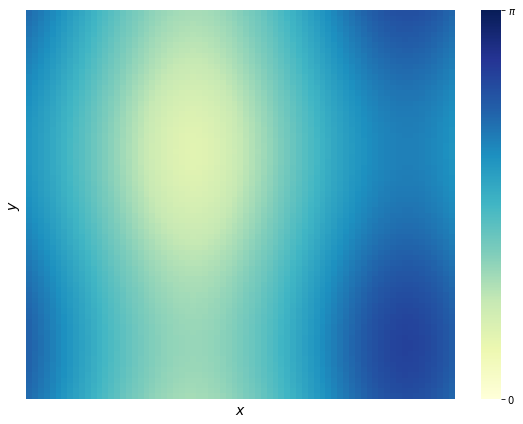

In [12]:
im_theta_np_t = np.array(list(im_theta_t.values()))
tehta_t_ = np.reshape(im_theta_np_t, (im_size_x, im_size_y))


plt.rcParams["figure.figsize"] = (8, 6)
ax = sns.heatmap(
    theta_t, cmap="YlGnBu", xticklabels=False, yticklabels=False, vmin=0, vmax=math.pi
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, math.pi])
cbar.set_ticklabels(["0", r"$\pi$"])
plt.tight_layout()
plt.show()

#### Reconstructed $\Theta$

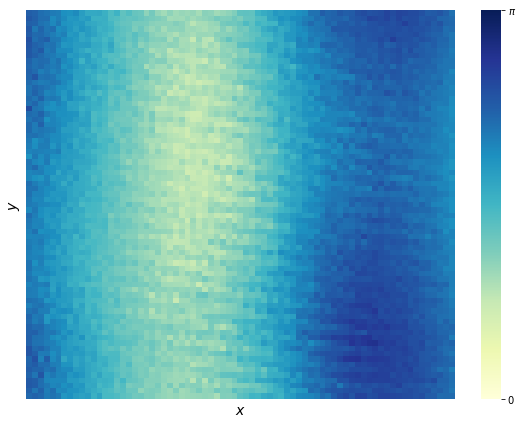

In [13]:
im_theta_np = np.array(list(im_theta.values()))
theta_ = np.reshape(im_theta_np, (im_size_x, im_size_y))


plt.rcParams["figure.figsize"] = (8, 6)
ax = sns.heatmap(
    theta_,
    cmap="YlGnBu",
    xticklabels=False,
    yticklabels=False,
    vmin=0,
    vmax=math.pi,
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, math.pi])
cbar.set_ticklabels(["0", r"$\pi$"])
plt.tight_layout()
plt.show()

#### Theoretical $n_x$

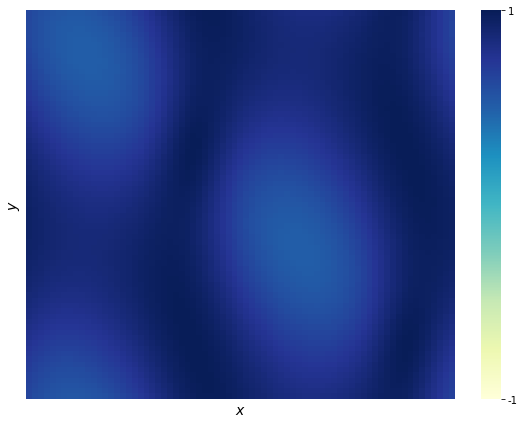

In [14]:
im_nx_np_t = np.array(list(im_nx_t.values()))
nx_t_ = np.reshape(im_nx_np_t, (im_size_x, im_size_y))

plt.rcParams["figure.figsize"] = (8, 6)
ax = sns.heatmap(
    nx_t, cmap="YlGnBu", xticklabels=False, yticklabels=False, vmin=-1, vmax=1
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(["-1", "1"])
plt.tight_layout()

#### Reconstructed $n_x$

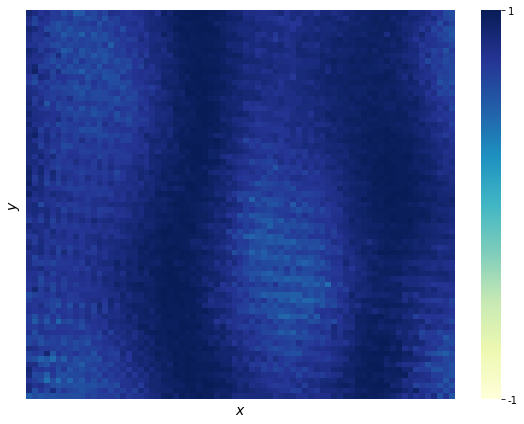

In [15]:
im_nx_np = np.array(list(im_nx.values()))
nx_ = np.reshape(-im_nx_np, (im_size_x, im_size_y))

plt.rcParams["figure.figsize"] = (8, 6)
ax = sns.heatmap(
    -nx_,
    cmap="YlGnBu",
    xticklabels=False,
    yticklabels=False,
    vmin=-1,
    vmax=1,
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(["-1", "1"])
plt.tight_layout()

#### Theoretical $n_y$

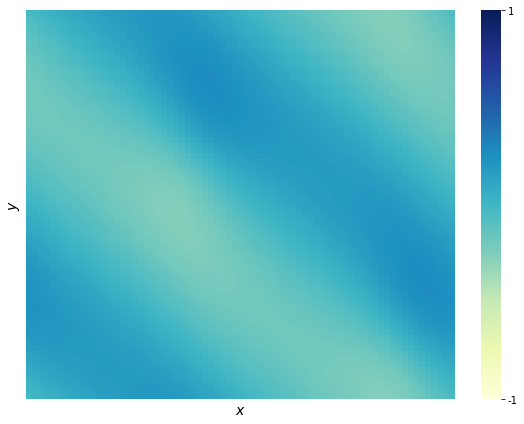

In [16]:
fig = plt.plot()
im_ny_np_t = np.array(list(im_ny_t.values()))
ny_t = np.reshape(im_ny_np_t, (im_size_x, im_size_y))


plt.rcParams["figure.figsize"] = (8, 6)
ax = sns.heatmap(
    ny_t, cmap="YlGnBu", xticklabels=False, yticklabels=False, vmin=-1, vmax=1
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(["-1", "1"])
plt.tight_layout()

#### Reconstructed $n_y$

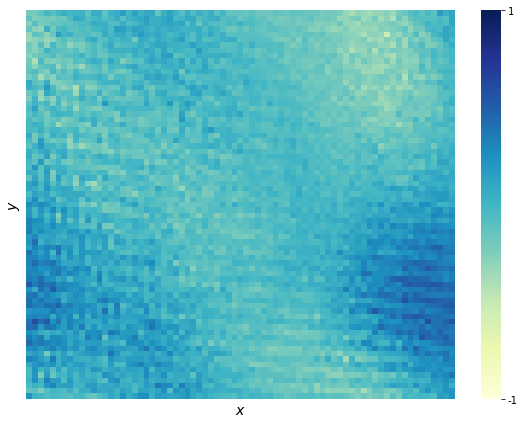

In [17]:
fig = plt.plot()
im_ny_np = np.array(list(im_ny.values()))
ny_ = np.reshape(im_ny_np, (im_size_x, im_size_y))

plt.rcParams["figure.figsize"] = (8, 6)
ax = sns.heatmap(
    ny_,
    cmap="YlGnBu",
    xticklabels=False,
    yticklabels=False,
    vmin=-1,
    vmax=1,
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(["-1", "1"])
plt.tight_layout()

#### Theoretical $n_z$

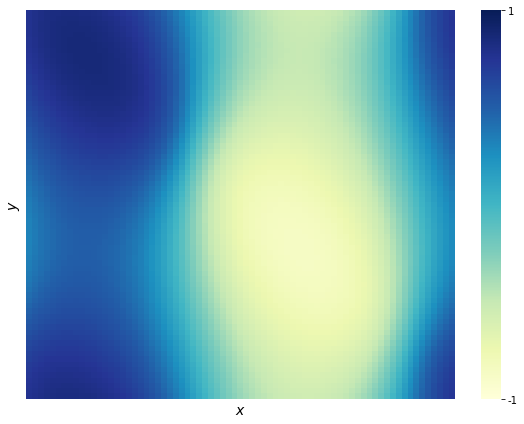

In [18]:
im_nz_np_t = np.array(list(im_nz_t.values()))
nz_t_ = np.reshape(im_nz_np_t, (im_size_x, im_size_y))

plt.rcParams["figure.figsize"] = (8, 6)
ax = sns.heatmap(
    nz_t, cmap="YlGnBu", xticklabels=False, yticklabels=False, vmin=-1, vmax=1
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(["-1", "1"])
plt.tight_layout()

#### Reconstructed $n_z$

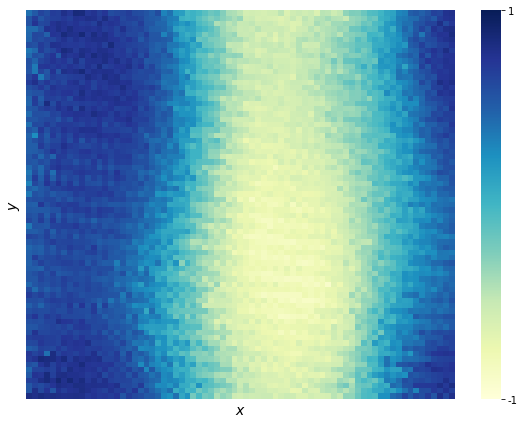

In [19]:
im_nz_np = np.array(list(im_nz.values()))
nz_ = np.reshape(im_nz_np, (im_size_x, im_size_y))


plt.rcParams["figure.figsize"] = (8, 6)
ax = sns.heatmap(
    nz_,
    cmap="YlGnBu",
    xticklabels=False,
    yticklabels=False,
    vmin=-1,
    vmax=1,
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(["-1", "1"])
plt.tight_layout()